In [1]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

from emu_filter.state_model import predict_states
from emu_filter.importance import truncnorm_importance
from emu_filter.outputs import get_counts_from_particles, plot_particle_results, get_links_from_pedigree, plot_links

In [2]:
# Inputs
contact_rate = 1.0
recovery_rate = 0.1
total_pop = 1000
inf_init = 12
n_particles = 100
observations = [0, 15, 40, 65, 124, 204, 252, 210]
target_sd = 50.0

In [3]:
# Initialise particles
particles = np.zeros([len(observations) + 1, 3, n_particles], dtype=int)
particles[0, 0, :] = total_pop - inf_init  # Susceptible
particles[0, 1, :] = inf_init  # Infectious
prop_particles = np.copy(particles)
pedigree = np.zeros([len(observations), n_particles], dtype=int)

# Main loop
for o, obs in enumerate(observations):
    
    # Prediction
    proposed_particles = predict_states(particles[o, :, :], contact_rate, recovery_rate, total_pop)
    prop_particles[o + 1, :] = proposed_particles

    # Importance
    weights = truncnorm_importance(proposed_particles[1, :], obs, target_sd)
    norm_weights = weights / sum(weights)

    # Resampling
    indices = np.random.choice(n_particles, size=n_particles, p=norm_weights)
    pedigree[o, :] = indices
    resamp_particles = proposed_particles[:, indices]
    
    # Update
    particles[o + 1, :, :] = resamp_particles

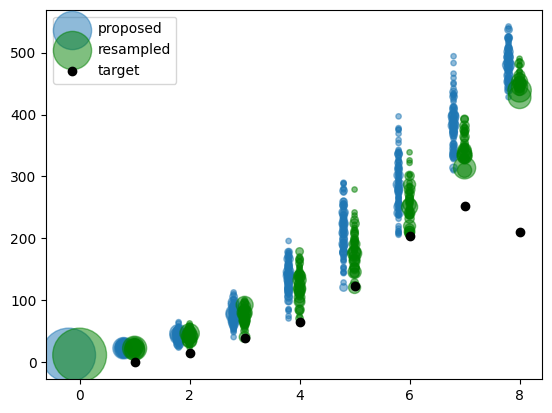

In [4]:
plot_particle_results(prop_particles, particles, observations)

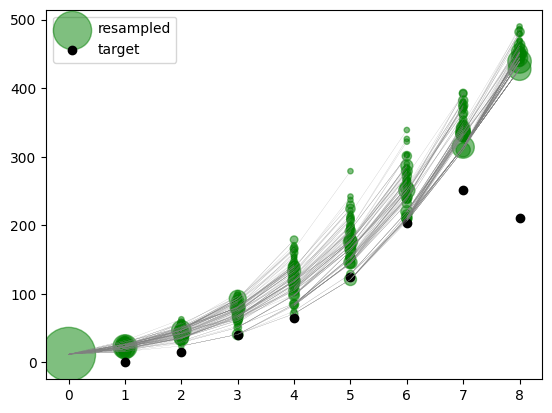

In [5]:
links = get_links_from_pedigree(particles, pedigree, observations)
plot_links(particles, links, observations)